In [532]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import wasserstein_distance
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import bernoulli

In [177]:
def ideal_distribution(N):
    """ Create the ideal soliton distribution. 
    In practice, this distribution gives not the best results
    Cf. https://en.wikipedia.org/wiki/Soliton_distribution
    """
    EPSILON = 10e-8

    probabilities = [0, 1 / N]
    probabilities += [1 / (k * (k - 1)) for k in range(2, N+1)]
    probabilities_sum = sum(probabilities)

    assert probabilities_sum >= 1 - EPSILON and probabilities_sum <= 1 + EPSILON, "The ideal distribution should be standardized"
    return probabilities

N = 100
idd = ideal_distribution(N)
#_=plt.hist(idd, bins='auto', range=(0,1/N))

In [533]:
star = 5

def poi_pmf(k, k_star=star, lmb=1):
    if k == k_star:
        #print("k_star")
        return 0
    elif k == k_star - 1:
        #print("k_star - 1")
        return poisson.pmf(k,lmb)+poisson.pmf(k_star,lmb)
    else:
        return poisson.pmf(k,lmb)

In [549]:
def get_poisson_pmf_array(n_max, poisson_param):
    poisson_arr = []
    
    for k in range(0,n_max):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

def get_binom_pmf_array(n, p=0):
    if p == 0:
        p = 1/n
        
    binom_arr = []
    
    for k in range(0,n):
        binom_pmf_k = binom.pmf(k, n, p)
        binom_arr.append(binom_pmf_k)
        
    return binom_arr

def binom_func(j,k,n):
    return scipy.special.binom(j,k) * (1/n)**k * (1-1/n)**(j-k)

def pmf_of_sum(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum(n-1,i)*poi_pmf(k-i) for i in range(0, k))

def get_thinning_pmf_array(n, rv=""):
    thinning_arr = []
    
    for k in range(0,n):
        thinning_pmf_k = pmf_of_sum(n, k)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr

def display_wasserstein_distance_info(w_range, n_range, text=""):

    print(f"W_1({text},Poisson) is monotonically decreasing: {is_monot_decreasing(w_range)}")
    print(f"W_1({text},Poisson) is monotonically increasing: {is_monot_increasing(w_range)}")
    print()
    
    plt.plot(n_range, w_range, c="black")
    plt.title(f"W_1({text},Poisson)")
    plt.show()
    
def plot_pmf(x, y, title=""):
    plt.plot(x, y, 'ro')
    plt.title(title)
    plt.show()
    
def get_relative_entropy(p1, p2=[]):
    if np.size(p2) == 0:
        return scipy.stats.entropy(p1)
    
    return scipy.stats.entropy(p1, p2)

def is_monot_increasing(arr):
    return all(float(fst) <= float(snd) for fst, snd in zip(arr, arr[1:]))

def is_monot_decreasing(arr):
    return all(float(fst) >= float(snd) for fst, snd in zip(arr, arr[1:]))

In [550]:
uniform_const = "Uniform"
soliton_const = "Soliton"
geometric_const = "Geometric"
binomial_const = "Binomial"
poisson_one_const = "Poisson(1)"
poisson_onehalf_const = "Poisson(1/2)"

poisson_with_hole_const = "Poisson with a hole in the support"
binomial_with_hole_const = "Binomial with a hole in the support"
uniform_with_hole_const = "Uniform with a hole in the support"

def thinning_pmf(n, k, rv):
    
    #c = (np.exp(-1/n)*(1/n)**k)/np.math.factorial(k) #with n=1, Y\sim Poisson(1). Does not make sense since we are interested in increasing n
    
    if rv == poisson_one_const:
        c = poisson.pmf(k,1)#1/(np.exp(1)*np.math.factorial(k)) #with Y_i\sim Poisson(1), i=1,...,n
        #print(c)
        #print(poisson.pmf(k,1))
        #print()
    
    if rv == poisson_onehalf_const:
        c = 0.5**k/(np.exp(0.5)*np.math.factorial(k)) #with Y_i\sim Poisson(0.5), i=1,...,n
    
    if rv == geometric_const:
        l = 0.5/n
        c = 1/(1+l)*(l/(1+l))**k #geometric
    
    if rv == binomial_const:
        c = binom.pmf(k, n, 1/n) #binomial
    
    if rv == soliton_const:
        # soliton distribution (https://en.wikipedia.org/wiki/Soliton_distribution)
        if k == 1:
            c = 1/n
        else:
            c = 1/(k*(k-1)) #k should be >0
        
    if rv == uniform_const:
        c = 1/n #uniform
    
    
    k_star = 5
    
    if rv == uniform_with_hole_const:
        if k < k_star:
            c = 1/(k_star)/2
        elif k == k_star:
            c = 0
        else:
            c = 1/(n-k_star-1)/2
                    
    if rv == poisson_with_hole_const:
        lmb = 1
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = poisson.pmf(k,lmb) + poisson.pmf(k_star,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)+np.exp(-lmb)*lmb**k_star/np.math.factorial(k_star)
        else:
            c = poisson.pmf(k,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)
    
    if rv == binomial_with_hole_const:
        p = 1/n
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = binom.pmf(k, n, p) + binom.pmf(k_star, n, p)
        else:
            c = binom.pmf(k, n, p)
        
    return c
    #print(c)
  

W_1(Binomial,Poisson) is monotonically decreasing: True
W_1(Binomial,Poisson) is monotonically increasing: False



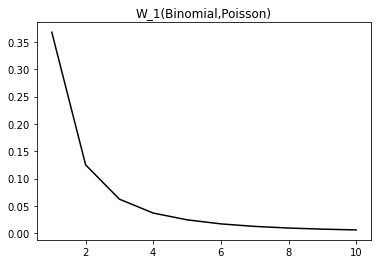

thinning pmf sum=0.36787944117144233, n=1
thinning pmf sum=0.1353352832366127, n=2
thinning pmf sum=0.04978706836786395, n=3
thinning pmf sum=0.018315638888734186, n=4
thinning pmf sum=0.00673794699908547, n=5
thinning pmf sum=0.0024787521766663594, n=6
thinning pmf sum=0.0009118819655545166, n=7
thinning pmf sum=0.00033546262790251196, n=8
thinning pmf sum=0.0001234098040866796, n=9
thinning pmf sum=4.539992976248487e-05, n=10
H(Binomial|Poisson) is monotonically decreasing: False (should always be true)
[0.0, 0.6931471805599453, 1.6094379124341003, 2.772588722239781, 4.174387269895637, 5.786897381366708, 7.579167967396076, 9.525151111816216, 11.604601777542019, 13.801827368655985]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

H(Binomial)_10=0.0, H(Poisson(1))=1.3048404554454895
H(Binomial|Poisson)=13.801827368655985


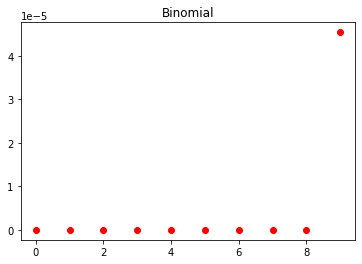

W_1(Thinning(Binomial),Poisson) is monotonically decreasing: False
W_1(Thinning(Binomial),Poisson) is monotonically increasing: False



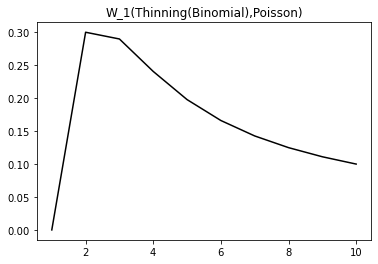

In [554]:
# Init
n_min = 1
n_max = 10
n_step = 1

poisson_param = 1

n_range = range(n_min,n_max+n_step,n_step)
k_range = range(n_min,n_max)

poisson_arr = get_poisson_pmf_array(n_max, poisson_param)
    
#print(f"poisson pmf sum={sum(poisson_arr)}")

# Law of small numbers
w_range = []
for n in n_range:
    binom_arr = get_binom_pmf_array(n, 1/n)
    
    #print(f"binom pmf sum={sum(binom_arr)}, n={n}")
    
    w = wasserstein_distance(poisson_arr[:n], binom_arr)
    w_range.append(w)
    #print(w)
    
#print(np.size(poisson_arr), np.size(binom_arr))
    
display_wasserstein_distance_info(w_range, n_range, "Binomial")

# Law of thin numbers
w_range = []

entropy = []
rel_entropy = []

thinning_rv = binomial_const

for n in n_range:
    thinning_arr = get_thinning_pmf_array(n, thinning_rv)
    
    print(f"thinning pmf sum={sum(thinning_arr)}, n={n}")

    w = wasserstein_distance(poisson_arr[:n], thinning_arr)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(thinning_arr, poisson_arr[:n]))
    entropy.append(get_relative_entropy(thinning_arr))


print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(poisson_arr)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")

plot_pmf(range(0,n), thinning_arr, title=thinning_rv)
#print(np.size(poisson_arr), np.size(thinning_arr))

    
display_wasserstein_distance_info(w_range, n_range, f"Thinning({thinning_rv})")


In [ ]:
n_step = 100

for n in range(1,10):
    sum_index_rv_new = bernoulli.rvs(0.5, size=n_step)
    sum_index_new = sum(sum_index_rv_new)
    
    sum_index = sum_index + sum_index_new
    
    thinning_arr = bernoulli.rvs(1/sum_index, size=sum_index)
    poisson_arr_new = poisson.rvs(mu=poisson_param, size=sum_index_new)

    np.append(poisson_arr, poisson_arr_new)
    
    w = wasserstein_distance(thinning_arr, poisson_arr)
    #print(w)

In [ ]:
print(wasserstein_distance(np.arange(3), np.arange(3), [1,0,0],[0,0.5,0.5]))

In [ ]:
sum_index_rv = bernoulli.rvs(0.5, size=n_initial)
sum_index = sum(sum_index_rv)

bernoulli_arr = bernoulli.rvs(1/sum_index, size=sum_index)
poisson_arr = poisson.rvs(mu=poisson_param, size=sum_index)

n_step = 1000

for n in range(1,10):

    sum_index = sum_index + n_step
    
    bernoulli_arr = bernoulli.rvs(1/sum_index, size=sum_index)
    poisson_arr_new = poisson.rvs(mu=poisson_param, size=n_step)

    np.append(poisson_arr, poisson_arr_new)
    
    w = wasserstein_distance(bernoulli_arr, poisson_arr)
    print(w)

In [ ]:
from mpmath import nsum, exp, inf

k = 10
n = 100

#s = nsum(lambda j: np.math.factorial(j+1)*(1-1/n)**(j-k)/np.math.factorial(j-k), [k, inf])

In [ ]:
def thinning_convolution(n,k):
    if n == 1:
        return thinning_pmf(n,k)
    
    return sum(thinning_convolution(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

In [541]:
k_star = 3

def binom_func(j,k,p):
    #print(j,k,p)
    #print(scipy.special.binom(j,k) * (p**k) * (1-p)**(j-k))
    #print()

    s = scipy.special.binom(j,k) * (p**k) * (1-p)**(j-k)
    return s

def pmf_of_sum(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

def thinning_pmf(n, k):
    #print(n)
    #return sum(pmf_of_sum(n,j) * binom_func(j,k,1/n) for j in range(k, k+10))
    #return sum(poisson.pmf(j,n) * binom.pmf(k,j,1/n) for j in range(k, k+300)) # does not work
    return sum(binom_func(n,j,0.5) * binom_func(j,k,1/n) for j in range(k, n+1)) # works
    #return sum(np.exp(-n)*n**j/np.math.factorial(j) * binom_func(j,k,1/n) for j in range(k, k+100))
    
def get_thinning_pmf_array(K,n):
    thinning_arr = []
    
    for k in range(0,K):
        thinning_pmf_k = thinning_pmf(n,k)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
    

0.36787944117144233
n=1, pmf sum=1.0


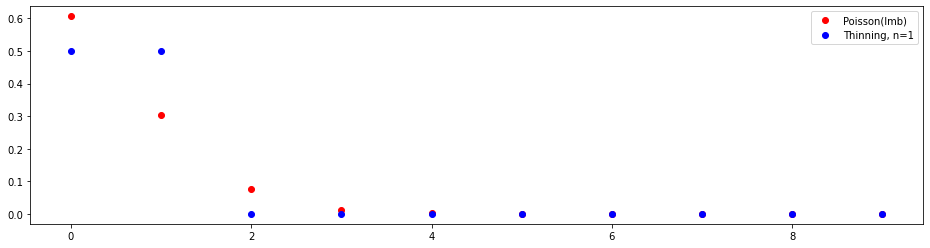

0.1353352832366127
n=2, pmf sum=1.0


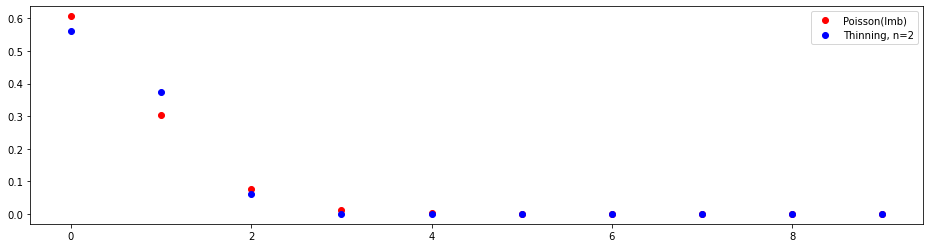

0.049787068367863944
n=3, pmf sum=1.0


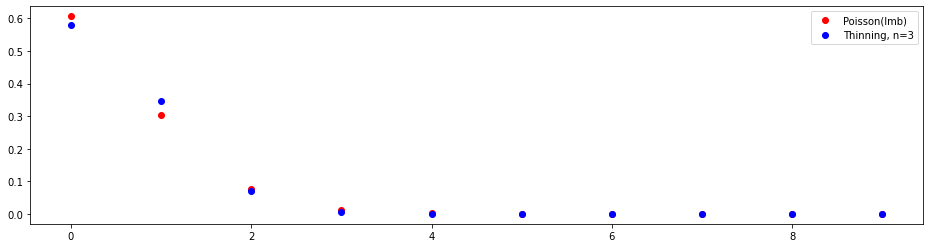

0.01831563888873418
n=4, pmf sum=1.0


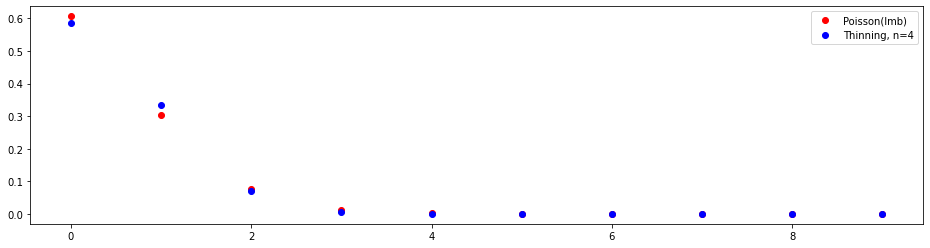

0.006737946999085467
n=5, pmf sum=1.0000000000000002


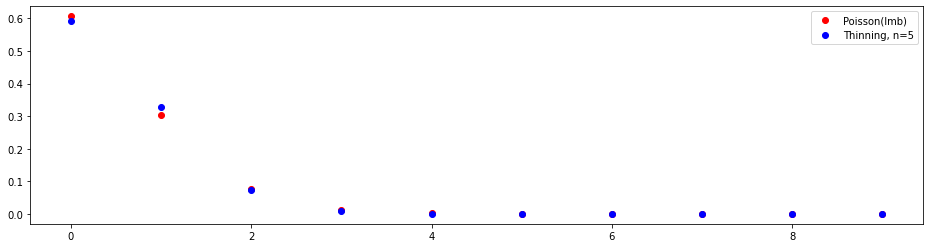

0.0024787521766663585
n=6, pmf sum=1.0


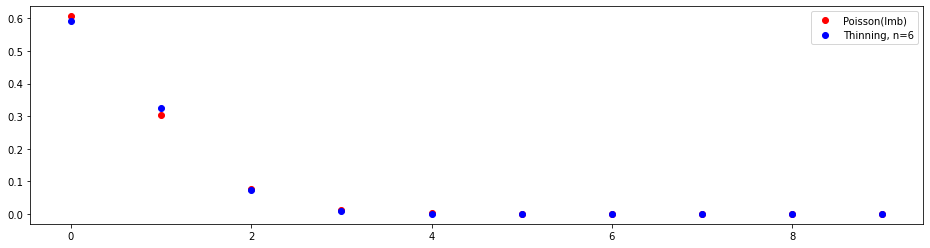

0.0009118819655545162
n=7, pmf sum=1.0000000000000002


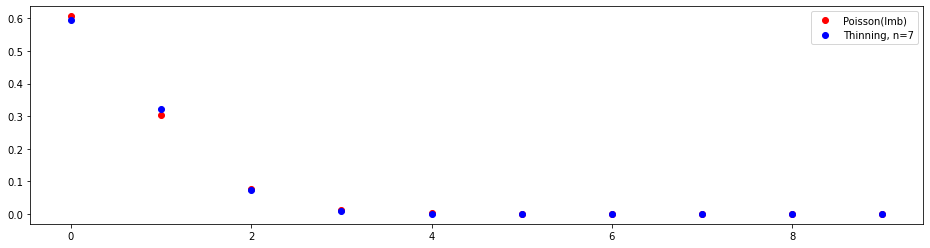

0.00033546262790251185
n=8, pmf sum=1.0


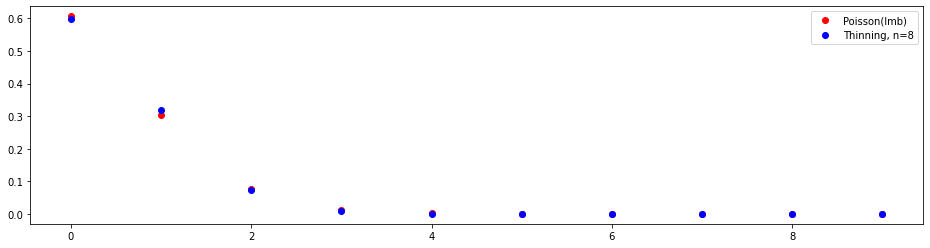

0.00012340980408667956
n=9, pmf sum=0.9999999999999997


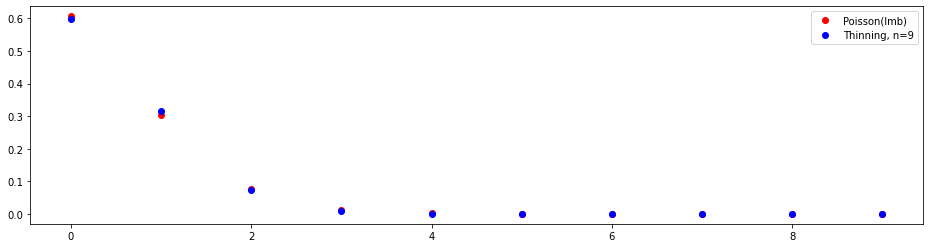

H(Binomial|Poisson) is monotonically decreasing: True (should always be true)
[0.15342640954906034, 0.02515519236636502, 0.009075487388596877, 0.004708272127753727, 0.0028901502235358766, 0.0019552235360311265, 0.0014107381103548075, 0.0010658422573339233, 0.0008336186467593275]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
[0.6931471805599453, 0.8647400965276372, 0.893928506320535, 0.9046418292247472, 0.9102051201901215, 0.9136116620956031, 0.9159095239797632, 0.9175629524918246, 0.9188091138070109]

H(Binomial)_10=0.9188091138070109, H(Poisson(1))=0.9276374636055427
H(Binomial|Poisson)=0.0008336186467593275

[0.03934693401163996, 0.014346934011639957, 0.008791378456084393, 0.006339121511639958, 0.004956934011639944, 0.004069718862463011, 0.0034519333104015134, 0.0029970112205165685, 0.0026480446906769393]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



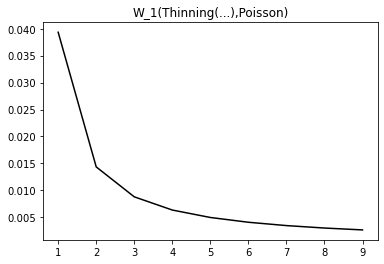

In [542]:
from decimal import Decimal

K = 10
K_range = range(0,K)

lmb = 0.5
p1 = get_poisson_pmf_array(K, lmb)
#print(sum(p1))
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 10
n_step = 1
n_range = range(1,n_max,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n)
    print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])
    plt.show()

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def renyi_thinning(x, alpha=2):
    # Generate random variables from a Poisson distribution
    n = np.random.poisson(x)

    # Calculate the thinning probability
    p = 1 / (1 + (alpha*(x**2)))

    # Generate a mask for thinning
    mask = np.random.uniform(size=n) < p

    return np.sum(mask)

# Parameters
alpha = 0.5
num_samples = 10000

# Generate samples
samples = [renyi_thinning(10, alpha) for _ in range(num_samples)]

# Calculate PMF
pmf, bins = np.histogram(samples, bins=np.arange(0, max(samples)+2)-0.5, density=True)

print(pmf)
# Plot PMF
plt.bar(bins[:-1], pmf, width=1)
plt.xlabel('Number of Thinned Points')
plt.ylabel('Probability')
plt.title('PMF of Renyi Thinning')
plt.show()

In [372]:
def renyi_thinning(x, alpha):
    # Generate random variables from a Poisson distribution
    n = np.random.poisson(x)

    # Calculate the thinning probability
    p = 1 / (1 + (alpha*(x**2)))

    # Generate a mask for thinning
    mask = np.random.uniform(size=n) < p

    return np.sum(mask)

# Parameters
n = 10
alpha = 1
num_samples = 10000

# Generate samples
samples = [renyi_thinning(10, alpha) for _ in range(num_samples)]
pmf, bins = np.histogram(samples, bins=np.arange(0, max(samples)+2)-0.5, density=True)
print(pmf)

[3.02433333e+00 0.00000000e+00 0.00000000e+00 2.93000000e-01
 0.00000000e+00 0.00000000e+00 1.50000000e-02 0.00000000e+00
 0.00000000e+00 1.00000000e-03]
